# FOREWORD AND METHODOLOGY:

In the Pokemon games, each type of pokemon is weak to some moves and resists others. Some types are also completely immune to 
another. A Water type move deals twice as much damage if it hits a Fire type pokemon, an Electric move will deal half damage
to a Grass type pokemon, a Ground type move will deal no damage to a Flying type pokemon, and so on.

I am attempting to discover how balanced these types are among each other. Is there an objective ranking of type strength? It is commonly believed that the typings Steel, Fairy, Dark, Fighting, and Dragon are among the strongest typings to have. Bug, Normal, and Grass are often seen as a liability. Will this hold up to analysis?

The program looks at type strength "in a vacuum," where 1/4 of the pokemon have only one type, and each dual-type combination 
is equally likely. This is not true of the actual game, where certain combinations (like Flying/Normal, Rock/Ground) 
are much more common than others (like Fire/Grass, which no pokemon has).

I simulate many attacks against randomly generated type combinations to see if any typings consistently rise to the top.
Each type will be given an offensive and a defensive score.

If an attacking move hits a defending pokemon for neutral damage, it will receive 1 offensive point. 
If the attacking move hits for super effective damage, it will receive 2 offensive points. Double super effective 
hits (like a ground type attack against an Electric/Fire pokemon) will get 4 points. 

A similar procedure goes for resistances and immunities: fire hitting a water pokemon will net it 0.5 offensive points.
Ghost hitting a normal type will net it 0 offensive points. Each type's score will then be averaged by the number of times it appeared in the simulation on each side.

The two types of a defending dual-type pokemon will each share the loss of defensive points each time they are attacked. This will help to account for synergy between defensive typings. For example, if a Water type move attacks a Fire/Electric pokemon, the water type move will get 2 offensive points. Fire and Electric will each lose two defensive points, even though Electric is not weak to Water. This may not seem fair at first, but consider next the case of a Ground move against Flying/Electric. Where Electric "deserves" to lose 2 defensive points, it actually will lose 0 because the Flying type makes it immune to the attacking Ground move.

# TL;DR:

Each typing is randomly used offensively and defensively.

Each attack deals "1" damage naturally, "2" if it's super effective, "1/2" if it's not very effective, or "0" if the defender is immune. This stacks multiplicatively if the defender has two types.

An overall offensive and defensive rating is given for each type, with a baseline rating of 100. These two are averaged to provide a final total ranking.


In [550]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def typesim(n):
    #Setting up the 18 pokemon types. Programming weaknesses, resistances, and immunities between types.
    #Yes, I'm hard entering this data. Sue me. It's not that large and it wasn't worth it going out and looking for the data 
    #elsewhere.
    #Lists of attacking values:
    
    normal = [1,1,1,1,1,1,0.5,0.5,1,0,1,1,1,1,1,1,1,1]
    fire = [1,0.5,0.5,2,1,1,0.5,2,1,1,1,1,1,1,0.5,2,2,1]
    water = [1,2,0.5,0.5,1,2,2,1,1,1,1,1,1,1,0.5,1,1,1]
    grass = [1,0.5,2,0.5,1,2,2,0.5,1,1,1,1,0.5,1,0.5,0.5,1,0.5]
    electric = [1,1,2,0.5,0.5,0,1,1,1,1,1,1,2,1,0.5,1,1,1]
    ground = [1,2,1,0.5,2,1,2,2,1,1,1,1,0,1,1,0.5,1,2]
    rock = [1,2,1,1,1,0.5,1,0.5,0.5,1,1,1,2,1,1,2,2,1]
    steel = [1,0.5,0.5,1,0.5,1,2,0.5,1,1,1,1,1,2,1,1,2,1]
    fighting = [2,1,1,1,1,1,2,2,1,0,0.5,2,0.5,0.5,1,0.5,2,0.5]
    ghost = [0,1,1,1,1,1,1,1,1,2,2,0.5,1,1,1,1,1,1]
    psychic = [1,1,1,1,1,1,1,0.5,2,1,0.5,0,1,1,1,1,1,2]
    dark = [1,1,1,1,1,1,1,1,0.5,2,2,0.5,1,0.5,1,1,1,1]
    flying = [1,1,1,2,0.5,1,0.5,0.5,2,1,1,1,1,1,1,2,1,1]
    fairy = [1,0.5,1,1,1,1,1,0.5,2,1,1,2,1,1,2,1,1,0.5]
    dragon = [1,1,1,1,1,1,1,0.5,1,1,1,1,1,0,2,1,1,1]
    bug = [1,0.5,1,2,1,1,1,0.5,0.5,0.5,2,2,0.5,0.5,1,1,1,0.5]
    ice = [1,0.5,0.5,2,1,2,1,0.5,1,1,1,1,2,1,2,1,0.5,1]
    poison = [1,1,1,2,1,0.5,0.5,0,1,0.5,1,1,1,2,1,1,1,0.5]
    
    #Using Pandas to create a type chart in a dataframe.
    types = [normal,fire,water,grass,electric,ground,rock,steel,fighting,ghost,psychic,dark,flying,fairy,dragon,bug,ice,poison]
    typenames = ["normal", "fire", "water", "grass", "electric", "ground", "rock", "steel", "fighting", "ghost", "psychic", "dark", "flying", "fairy", "dragon", "bug", "ice", "poison"]
    global typechart
    typechart = pd.DataFrame(types, columns=typenames,index=typenames)
    
    #Initializing type offensive and defensive score lists and counts for later:  
    global offense_score
    offense_score = [0]*18
    global offense_count
    offense_count = [0]*18
    global defense_score
    defense_score = [0]*18
    global defense_count
    defense_count = [0]*18
    global offense_avg
    offense_avg = [0]*18
    global defense_avg
    defense_avg = [0]*18

            
    
    #Generating n random matchups. I generate a random number x to make about 1/4 of pokemon have only one type, which is about the proportion of competitive pokemon in the gen 8 OU format that were monotype. 
    for i in range(1,n+1):

        #Generating random types for each pokemon
        type1 = np.random.randint(0,18)
        type2 = np.random.randint(0,18)
        type3 = np.random.randint(0,18)
        
        #Rerolling type 2 if it matches type 1:
        while (type1 == type2):
            type2 = np.random.randint(0,18)
       
        #Forcing 1/4 of defending pokemon on average to only have 1 type, and then making the attacks:
        x = np.random.uniform(0,1)
       
        #Attacks into mono-type pokemon
        if (x <= 0.25):
            attack_value = typechart.iloc[type3, type1]
            
            offense_score[type3] += attack_value
            offense_count[type3] += 1
    
            defense_score[type1] += attack_value
            defense_count[type1] += 1
        
        #Attacks into dual-type pokemon
        else:
            attack_value = typechart.iloc[type3, type1] * typechart.iloc[type3, type2]
            
            offense_score[type3] += attack_value
            offense_count[type3] += 1
           
            defense_score[type1] += attack_value
            defense_count[type1] += 1
        
            defense_score[type2] += attack_value
            defense_count[type2] += 1
    
    #Applying the average to the scores and applying an adjustment to the scores
    for j in range(len(offense_avg)):
        offense_avg[j] = (offense_score[j]/offense_count[j])
        defense_avg[j] = (defense_score[j]/defense_count[j])
    
    
    global offense_final
    offense_final = [0]*18
    global defense_final
    defense_final = [0]*18
    
    #Final scores: 
    
    #Offense: Represents the average amount of damage this type's attack will do to a defender with a 
    #randomly selected type combination
    
    #Defense: Represents what amount/percentage of damage a type will be expected to take if a randomly 
    #typed attack deals 100 damage to a neutral target. This figure accounts for dual class synergies.
    
    defense_avg_min = min(defense_avg)

    for m in range(len(offense_avg)):
        offense_final[m] = round(offense_avg[m]*100, 2)
        #Here I flip defense about 1 so that a rating above 100 is good. This is useful so that the mean between the two scores
        #will make a good overall score
        defense_final[m] = (1 + (1-defense_avg[m]))
        defense_final[m] = round(defense_final[m]*100, 2)
        
                
        


        

In [551]:
#Here I run a million attacks. You can change it however you would like.
typesim(1000000)

data = pd.DataFrame(offense_final, columns=["offense"], index=typenames)
data['defense'] = defense_final
score = [0]*18

for i in range(18):
    score[i] = (data['offense'][i] + data['defense'][i])/2
data['average'] = score
data

,offense,defense,average
normal,81.16,96.46,88.810
fire,119.32,96.84,108.080
water,113.99,98.79,106.390
grass,93.81,82.08,87.945
electric,94.19,99.09,96.640
ground,129.61,91.86,110.735
rock,124.84,80.49,102.665
steel,108.93,112.54,110.735
fighting,113.94,89.37,101.655
ghost,104.33,102.17,103.250


Text(0, 0.5, 'Defensive Rating')

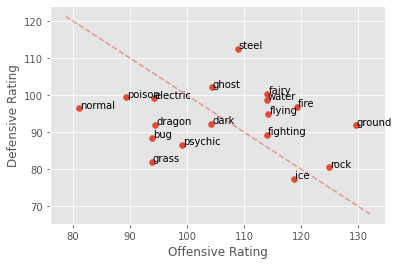

In [552]:
#Visualizing the initial results. Plotting combined offense/defense scores. A rough look is good enough for my purposes here;
#no need to break out Tableau

fig, ax = plt.subplots()
ax.scatter(data['offense'], data['defense'])

for i, name in enumerate(typenames):
    #Change these to offense_final2[i] and defense_final2[i] if you moved the labels
    ax.annotate(name, (data['offense'][i]+0.15, data['defense'][i]+0.1))
                                                    
def abline(slope, intercept):
    #Plots a line from slope and intercept. Credit to David Marx:
    #https://stackoverflow.com/questions/7941226/how-to-add-line-based-on-slope-and-intercept-in-matplotlib
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--', alpha=0.5)
    
abline(-1, 200)

plt.xlabel("Offensive Rating")
plt.ylabel("Defensive Rating")

#Greater distance *perpendicular* to the dotted line 
#represents strength if the distance is above/right and weakness if it is below/left

Text(0.5, 0, 'Overall Score')

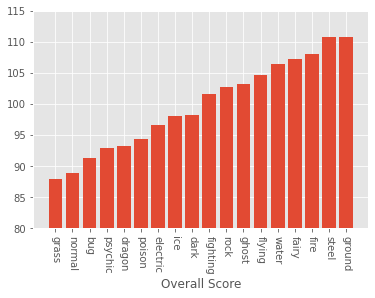

In [553]:
#Plotting the Overall Score

sorted_data = data.sort_values('average')

plt.bar(sorted_data.index.values,sorted_data['average'])
plt.ylim(80,115)
plt.xticks(rotation = 270)
plt.xlabel("Overall Score")

#An Overall Score of 100 is a baseline, average-strength typing overall. Lower scores represent weaker types, while
#higher scores represent better types.

In [554]:
sorted_data

,offense,defense,average
grass,93.81,82.08,87.945
normal,81.16,96.46,88.810
bug,93.93,88.48,91.205
psychic,99.18,86.67,92.925
dragon,94.48,92.05,93.265
poison,89.30,99.47,94.385
electric,94.19,99.09,96.640
ice,118.73,77.44,98.085
dark,104.25,92.27,98.260
fighting,113.94,89.37,101.655


# Overall Results

The simulation usually finds the Ground type as the strongest when all combinations are equally likely, with the Steel type nipping at its heels. Fairy, commonly believed to be strong, indeed comes out looking favorable at fourth place.

Normal, Grass, and Bug are the three weakest types, which aligns very closely with common belief. They lack defensive synergy and have poor offensive coverage.

Immunities have huge implications on the rankings. Dragon type, for example, sits at 4th weakest out of all classes despite having 4 solid resistances and only 3 weaknesses. Since Fairy is immune to Dragon attacks, it knocks the type way down the chart.


# Notes on interesting outcomes:

Steel - This type is probably the strongest of all of them in reality. Steel does tend to have weak base power on its commonly used moves, leaving it with an offensive rating higher than it probably deserves.

Ground - This type looks like an offensive powerhouse. It's true that the Ground type has extremely strong coverage, which is mostly what is being measured by this simulation. However, the frequent use of Grassy Terrain, the ability Levitate, and the painful consequences of missing a turn due to Flying type's immunity are all major inhibitors that dampen the huge "blind" offensive value of the Ground type in reality.

Rock and Ice - Each can be described as a true offensive powerhouse, with a huge defensive liability.

Normal - Isn't super effective against anything on offense, and suffers from the ghost immunity. In this simulation, all type combinations are equally likely, so any time a typing pairs with ghost, the normal attack deals 0. This really hurts its offensive score despite few glaring weaknesses in the type.

Fighting - Sits at about dead average in the "blind" test, but in reality is among the best types. For similar reasons, Fighting gets its offensive score really hurt by the Ghost immunity. Luckily, there are many super effective hits for Fighting, so it doesn't suffer as hard as Normal types do.


# Weaknesses of this simulation:

1. Does not account for dual-type offensive coverage. 
A Fire type can't hit a Water type well, but if the attacker was Fire/Electric, it would have additional "coverage" for Water by using that Electric typing instead.

2. Does not account for how common different combinations of types are.
As I mentioned earlier, there are no Fire/Grass dual-type pokemon. However, this is still a possibility in the simulation.

3. Does not account for typical stat totals of each type.
Psychic type pokemon typically have a lower Defense than Special Defense stat, for example. So even though Ghost is super effective against Psychic, because Ghost moves are typically Special Attacking moves, they may end up being less effective against a Psychic pokemon than a neutral physical Rock move.

4. Does not account for strength, accuracy, or utility of each attacking type's moves.
The most common Fairy type move, Moonblast, has a strong base power and a chance to lower the opponent's special attack.
This makes it more useful than a Water move like Surf, which only deals damage.
Stone Edge and Focus Blast are also infamous for having lower than 100 accuracy, meaning they can miss and deal no damage
when used on any given turn.

5. Does not account for immunities from abilities like Levitate, Water Absorb, Scrappy, etc...
Many Poison and Electric pokemon have the ability Levitate, which allows them to be immune to Ground type attacks that
would normally do super effective damage against them. This makes Ground attacks less useful, since some of their good matchups
actually end up being major liabilities against their offensive power.

6. Does not account for the metagame at all.
In Pokemon games, particular species of pokemon are so widely used by players that any type that is effective against them deserves an extra bump. For example, Clefable has recently been widely used as due to its flexibility, strong defensive abilities, and general tankiness. Any type that can perform well against Clefable, which is a Fairy type, is therefore more valuable within the metagame. Since this is not considered at all by the simulations, don't take this model *too* seriously. This is the most glaring weakness of this simulation.

7. Does not account for Entry Hazards, especially Stealth Rock.
This is somewhat advanced, so I ignore it for now. Types that resist Rock become especially useful on the defensive side because of Stealth Rock.

8. Only deals with single battles.
But who even likes VGC, anyway?

If I find some more time, maybe I'll devise solutions for these problems. Many of them can be solved by loading up a database of actual pokemon and joining it with real usage data (perhaps from Smogon?).




# About Me:

I am Joey Di Conza. I'm a frequent gamer and occasional gambler with a passion for statistics. Watch out for me at the poker table. I'm the recent recipient of a degree in Mathematics and Statistics from the University of Utah who is currently on the job hunt. I'd love a data science or software engineering position, and I'm willing to move anywhere in the US for a good fit.

All of this was done by me out of curiosity, just for fun. I know, I'm a masochist. My intended audience is somewhere between a potential employer and a random Redditor.

Shoutouts to PokeaimMD, Blunder (agency, agency), and Emvee for their awesome Pokemon content. Check 'em out on YouTube and Twitch!

For any questions about the project or any mistakes you stumble upon, contact me via email at joey@diconza.com with "Pokemon Simulation" somewhere in the subject line!